# First Petals TPU Model

In [1]:
import pandas as pd
import math, re, os
import tensorflow as tf
from tensorflow import keras
from kaggle_datasets import KaggleDatasets
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, callbacks
import matplotlib.pyplot as plt

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


# Detect my accelerator

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Get my data path

In [3]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started') # you can list the bucket with "!gsutil ls $GCS_DS_PATH"

# Set some parameters

In [4]:
IMAGE_SIZE = [512, 512] # at this size, a GPU will run out of memory. Use the TPU
EPOCHS = 30
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

NUM_TRAINING_IMAGES = 12753
NUM_TEST_IMAGES = 7382
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

# Load my data

This data is loaded from Kaggle and automatically sharded to maximize parallelization.

In [5]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-512x512/train/*.tfrec'), labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-512x512/val/*.tfrec'), labeled=True, ordered=False)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-512x512/test/*.tfrec'), labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()

# Build a model on TPU (or GPU, or CPU...) with Tensorflow 2.1!

In [6]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=12, # how many epochs to wait before stopping
    restore_best_weights=True,
)

with strategy.scope():    
    pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = False # tramsfer learning
    
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        tf.keras.layers.Dense(104, activation='softmax')
    ])
        
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

historical = model.fit(training_dataset,
                       steps_per_epoch=STEPS_PER_EPOCH,
                       epochs=EPOCHS,
                       callbacks=[early_stopping],
                       validation_data=validation_dataset)

58892288/58889256 [==============================] - 0s 0us/step
Epoch 1/30
99/99 [==============================] - 124s 1s/step - loss: 4.1171 - sparse_categorical_accuracy: 0.1632 - val_loss: 3.9692 - val_sparse_categorical_accuracy: 0.0991
Epoch 2/30
99/99 [==============================] - 63s 646ms/step - loss: 2.6800 - sparse_categorical_accuracy: 0.3503 - val_loss: 3.4308 - val_sparse_categorical_accuracy: 0.2169
Epoch 3/30
99/99 [==============================] - 64s 649ms/step - loss: 2.3293 - sparse_categorical_accuracy: 0.4132 - val_loss: 2.7872 - val_sparse_categorical_accuracy: 0.3443
Epoch 4/30
99/99 [==============================] - 64s 647ms/step - loss: 2.1594 - sparse_categorical_accuracy: 0.4422 - val_loss: 2.1353 - val_sparse_categorical_accuracy: 0.4677
Epoch 5/30
99/99 [==============================] - 64s 652ms/step - loss: 2.0247 - sparse_categorical_accuracy: 0.4729 - val_loss: 1.6535 - val_sparse_categorical_accuracy: 0.5784
Epoch 6/30
99/99 [==============

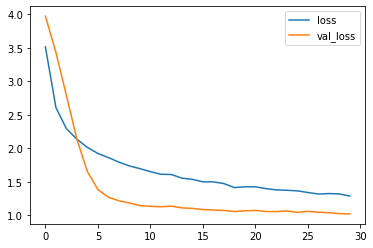

In [7]:
# convert the training history to a dataframe
history_df = pd.DataFrame(historical.history)
# use Pandas native plot method
history_df[['loss', 'val_loss']].plot();

# Compute your predictions on the test set!

This will create a file that can be submitted to the competition.

In [8]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

Computing predictions...
[67 52 81 ... 14 40 79]
Generating submission.csv file...
